In [5]:
%reset
import sys, os
import traceback
import pdb
import numpy as np
import scipy as sp
import scipy.special as spsp
from scipy import interpolate
import astropy.units as u
from astropy import constants as const
import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
import copy
import itertools
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/helper/')
import mycosmo as cosmodef
from twobessel import *
import LSS_funcs as hmf
import plot_funcs as pf
import multiprocessing
import time
import pdb
import pickle as pk
import dill
from mcfit import Hankel

pi = np.pi

import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')


import pickle as pk
import numpy as np
import pickle as pk
import matplotlib
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
# import matplotlib
from astropy.io import fits
import sys, os
import dill
# %pylab inline

os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'

# sys.path.insert(0, '../../../helper/')
sys.path.insert(0, '../cosmosis_code/')

from pressure import *
from get_theory_interface import *
from general_hm import *





Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
class Pressure_hy:
    """
    Sets up the pressure profile functions.
    """
    def __init__(self, cosmo_params, pressure_params, other_params):
        cosmology.addCosmology('mock_cosmo', cosmo_params)
        self.cosmo_colossus = cosmology.setCosmology('mock_cosmo')
#        self.cosmo_colossus = cosmology.setCosmology('planck18')
        h = cosmo_params['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params['Om0'], cosmo_params['Ob0'], cosmo_params['ns'],
                                          cosmo_params['sigma8'])
        self.cosmo = cosmo_func
        self.verbose = other_params['verbose']

        self.z_array = other_params['z_array']

        self.do_split_params_massbins = other_params['do_split_params_massbins']
        self.pressure_params_dict = pressure_params
        self.use_multiprocess = other_params['use_multiprocess']

        self.pressure_model_type = other_params['pressure_model_type']
        self.pressure_model_name = other_params['pressure_model_name']
        self.pressure_model_mdef = other_params['pressure_model_mdef']
        self.mdef_analysis = other_params['mdef_analysis']
        self.pressure_model_delta = other_params['pressure_model_delta']

        self.other_params = other_params

        if self.do_split_params_massbins:
            self.split_params_massbins_names = other_params['split_params_massbins_names']
            self.split_mass_bins_min = other_params['split_mass_bins_min']
            self.split_mass_bins_max = other_params['split_mass_bins_max']
            self.split_mass_bins_centers = other_params['split_mass_bins_centers']


    def get_gnfwp_Battaglia12(self, M_mat_shape_nz_nm, x_array, z_array, Mmat_cond=None, zmat_cond=None):
        # pdb.set_trace()
        pressure_fid = self.other_params['pressure_fid']
        nz, nm = M_mat_shape_nz_nm.shape
        nx = len(x_array)
        xmat = np.tile(x_array.reshape(1, 1, nx), (nz, nm, 1))

        if 'B12new' in self.pressure_params_dict['logMstar'].keys():
            pivot_B12 = 10 ** self.pressure_params_dict['logMstar']['B12']
            pivot_new = 10 ** self.pressure_params_dict['logMstar']['B12new']
            pivot_ratio = pivot_new / pivot_B12
            M_mat_no_h__Mstar = (np.tile(M_mat_shape_nz_nm.reshape(nz, nm, 1), (1, 1, nx))) / (
                    self.cosmo.h * (10 ** self.pressure_params_dict['logMstar']['B12new']))
        else:
            pivot_ratio = 1.
            M_mat_no_h__Mstar = (np.tile(M_mat_shape_nz_nm.reshape(nz, nm, 1), (1, 1, nx))) / (
                    self.cosmo.h * (10 ** self.pressure_params_dict['logMstar']['B12']))

        #######################################
        # BEWARE!! ONLY WORKS WHEN M_MAT_SHAPE_NZ_NM IS IN SAME MDEF AS LOG_M_MIN_TRACER
        ######################################
        Mmat_cond = np.logical_and(M_mat_shape_nz_nm >= (10 ** self.other_params['log_M_min_tracer']),
                                   M_mat_shape_nz_nm <= (10 ** self.other_params['log_M_max_tracer']))
        zmat = np.tile(z_array.reshape(nz, 1), (1, nm))
        zmat_cond = np.logical_and(zmat >= (self.other_params['zmin_tracer']),
                                   zmat <= (self.other_params['zmax_tracer']))

        Mmat_cond_nx = (np.tile(Mmat_cond.reshape(nz, nm, 1), (1, 1, nx)))
        zmat_cond_nx = (np.tile(zmat_cond.reshape(nz, nm, 1), (1, 1, nx)))

        def get_cond_var(var_name, new_val_dict=self.pressure_params_dict, fid_val_dict=pressure_fid,
                         cond_mat_m=Mmat_cond_nx, cond_mat_z=zmat_cond_nx):
            new_val = new_val_dict[var_name]
            fid_val = fid_val_dict[var_name]
            cond_mat_f = np.logical_and(cond_mat_m, cond_mat_z)
            negcond_mat_f = np.logical_not(cond_mat_f)

            result = new_val * cond_mat_f + fid_val * negcond_mat_f
            # pdb.set_trace()

            return result

        gamma_Am = get_cond_var('gamma-A_m') * (pivot_ratio ** get_cond_var('gamma-alpha_m'))
        alpha_Am = get_cond_var('alpha-A_m') * (pivot_ratio ** get_cond_var('alpha-alpha_m'))
        beta_Am = get_cond_var('beta-A_m') * (pivot_ratio ** get_cond_var('beta-alpha_m'))
        xc_Am = get_cond_var('xc-A_m') * (pivot_ratio ** get_cond_var('xc-alpha_m'))
        P0_Am = get_cond_var('P0-A_m') * (pivot_ratio ** get_cond_var('P0-alpha_m'))
#        import ipdb; ipdb.set_trace()
        one_plus_z_mat = 1 + np.tile(z_array.reshape(nz, 1, 1), (1, nm, nx))

        gamma_mat = gamma_Am * (M_mat_no_h__Mstar ** get_cond_var('gamma-alpha_m')) * (
                one_plus_z_mat ** get_cond_var('gamma-alpha_z'))

        alpha_mat = alpha_Am * (M_mat_no_h__Mstar ** get_cond_var('alpha-alpha_m')) * (
                one_plus_z_mat ** get_cond_var('alpha-alpha_z'))

        beta_mat = beta_Am * (M_mat_no_h__Mstar ** get_cond_var('beta-alpha_m')) * (
                one_plus_z_mat ** get_cond_var('beta-alpha_z'))

        xc_mat = xc_Am * (M_mat_no_h__Mstar ** get_cond_var('xc-alpha_m')) * (
                one_plus_z_mat ** get_cond_var('xc-alpha_z'))

        P0_mat = P0_Am * (M_mat_no_h__Mstar ** get_cond_var('P0-alpha_m')) * (
                one_plus_z_mat ** get_cond_var('P0-alpha_z'))

        del one_plus_z_mat, M_mat_no_h__Mstar

        val1 = np.power(xmat / xc_mat, gamma_mat)
        del gamma_mat

        val2 = np.power(1. + np.power(xmat / xc_mat, alpha_mat), -1.0 * beta_mat)
        del alpha_mat, beta_mat, xc_mat, xmat,

        valf = P0_mat * val1 * val2


        return valf

    def get_Pe_mat_Battaglia12(self, M_mat_Delta, x_array, z_array, R_mat_Delta, M200c_mat=None, mdef_Delta=None,
                               Mmat_cond=None, zmat_cond=None):
        nz, nm = M_mat_Delta.shape

        if mdef_Delta is None:
            mdef_Delta = self.other_params['pressure_model_mdef']

        if M200c_mat is None:
            if self.verbose:
                print('changing mdef to 200c for battaglia profiles in function get_Pe_mat_Battaglia12')

                ti = time.time()

            halo_conc_Delta = np.zeros(M_mat_Delta.shape)
            # pdb.set_trace()
            for j in range(len(z_array)):
                M_array = M_mat_Delta[j, :]
                halo_conc_Delta[j, :] = concentration.concentration(M_array, mdef_Delta, z_array[j])

            M200c_mat, R200c_mat_kpc_h = np.zeros(M_mat_Delta.shape), np.zeros(M_mat_Delta.shape)
            for j in range(nz):
                M200c_mat[j, :], R200c_mat_kpc_h[j, :], _ = mass_defs.changeMassDefinition(M_mat_Delta[j, :],
                                                                                           halo_conc_Delta[j, :],
                                                                                           z_array[j], mdef_Delta,
                                                                                           '200c')

            hydro_B = self.pressure_params_dict['hydro_mb']
            M200c_mat = M200c_mat / hydro_B

            if self.verbose:
                print('that took ', time.time() - ti, 'seconds')

        # print('M200c=' + str(np.log10(M200c_mat)))

        nz, nm = M_mat_Delta.shape
        nx = len(x_array)
        # units (Msun) / (Mpc ** 3)
        rho_crit_array = self.cosmo_colossus.rho_c(z_array) * (1000 ** 3) * (self.cosmo.h ** 2)
        rho_crit_mat = np.tile(rho_crit_array.reshape(nz, 1, 1), (1, nm, nx))
        M_mat_Delta_no_h = (M_mat_Delta / self.cosmo.h)
        R_mat_Delta_no_h = (R_mat_Delta / self.cosmo.h)
        M_mat_Delta_no_h_nz_nm_nx = np.tile(M_mat_Delta_no_h.reshape(nz, nm, 1), (1, 1, nx))
        R_mat_Delta_no_h_nz_nm_nx = np.tile(R_mat_Delta_no_h.reshape(nz, nm, 1), (1, 1, nx))
        coeff = (const.G * (const.M_sun ** 2) / ((1.0 * u.Mpc) ** 4)).to((u.eV / (u.cm ** 3))).value

        pressure_model_delta = float(''.join(list(mdef_Delta)[:-1]))
        P_Delta = (coeff / 2.) * pressure_model_delta * (
                self.cosmo.Ob0 / self.cosmo.Om0) * M_mat_Delta_no_h_nz_nm_nx * rho_crit_mat / R_mat_Delta_no_h_nz_nm_nx

        gnfw_P = self.get_gnfwp_Battaglia12(M200c_mat, x_array, z_array, Mmat_cond=Mmat_cond, zmat_cond=zmat_cond)
        M200c_mat_no_h = (M200c_mat / self.cosmo.h)
        M200c_mat_no_h_nz_nm_nx = np.tile(M200c_mat_no_h.reshape(nz, nm, 1), (1, 1, nx))

        if self.pressure_model_type == 'lowbroken_powerlaw':
            M_mat_cond_shape_nz_nm = []
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h < (10 ** self.pressure_params_dict['logMstar']['alpha_p_low']))
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h > (10 ** self.pressure_params_dict['logMstar']['alpha_p_low']))

            alpha_p_array = np.zeros((nz, nm))
            for i in range(2):
                if i == 0:
                    alpha_p_array += self.pressure_params_dict['alpha_p_low'] * M_mat_cond_shape_nz_nm[i]
                else:
                    alpha_p_array += 0.0 * M_mat_cond_shape_nz_nm[i]

            alpha_p_mat = np.tile(alpha_p_array.reshape(nz, nm, 1), (1, 1, nx))
            M_mat_coeff = np.power(
                (M200c_mat_no_h_nz_nm_nx / (10 ** self.pressure_params_dict['logMstar']['alpha_p_low'])),
                alpha_p_mat)

        elif self.pressure_model_type == 'highbroken_powerlaw':
            M_mat_cond_shape_nz_nm = []
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h < (10 ** self.pressure_params_dict['logMstar']['alpha_p_high']))
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h > (10 ** self.pressure_params_dict['logMstar']['alpha_p_high']))

            alpha_p_array = np.zeros((nz, nm))
            for i in range(2):
                if i == 0:
                    alpha_p_array += self.pressure_params_dict['alpha_p_high'] * M_mat_cond_shape_nz_nm[i]
                else:
                    alpha_p_array += 0.0 * M_mat_cond_shape_nz_nm[i]

            alpha_p_mat = np.tile(alpha_p_array.reshape(nz, nm, 1), (1, 1, nx))
            M_mat_coeff = np.power(
                (M200c_mat_no_h_nz_nm_nx / (10 ** self.pressure_params_dict['logMstar']['alpha_p_high'])),
                alpha_p_mat)

        elif self.pressure_model_type == 'doublybroken_powerlaw':
            M_mat_cond_shape_nz_nm = []
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h < (10 ** self.pressure_params_dict['logMstar']['alpha_p_low']))
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h > (10 ** self.pressure_params_dict['logMstar']['alpha_p_low']))

            alpha_p_array = np.zeros((nz, nm))
            for i in range(2):
                if i == 0:
                    alpha_p_array += self.pressure_params_dict['alpha_p_low'] * M_mat_cond_shape_nz_nm[i]
                else:
                    alpha_p_array += 0.0 * M_mat_cond_shape_nz_nm[i]

            alpha_p_mat = np.tile(alpha_p_array.reshape(nz, nm, 1), (1, 1, nx))
            M_mat_coeff1 = np.power(
                (M200c_mat_no_h_nz_nm_nx / (10 ** self.pressure_params_dict['logMstar']['alpha_p_low'])),
                alpha_p_mat)

            M_mat_cond_shape_nz_nm = []
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h < (10 ** self.pressure_params_dict['logMstar']['alpha_p_high']))
            M_mat_cond_shape_nz_nm.append(
                M200c_mat_no_h > (10 ** self.pressure_params_dict['logMstar']['alpha_p_high']))

            alpha_p_array = np.zeros((nz, nm))
            for i in range(2):
                if i == 0:
                    alpha_p_array += self.pressure_params_dict['alpha_p_high'] * M_mat_cond_shape_nz_nm[i]
                else:
                    alpha_p_array += 0.0 * M_mat_cond_shape_nz_nm[i]

            alpha_p_mat = np.tile(alpha_p_array.reshape(nz, nm, 1), (1, 1, nx))
            M_mat_coeff2 = np.power(
                (M200c_mat_no_h_nz_nm_nx / (10 ** self.pressure_params_dict['logMstar']['alpha_p_high'])),
                alpha_p_mat)

            M_mat_coeff = M_mat_coeff1 * M_mat_coeff2

            # pdb.set_trace()

        else:
            M_mat_coeff = np.ones((nz, nm, nx))


        Pe_mat = 0.518 * P_Delta * gnfw_P * M_mat_coeff

        # np.savez('Pe_mat_comp_B12_zmax1.npz',Pe=Pe_mat,M200c_mat=M200c_mat,x=x_array,z=z_array,r500c=R_mat_Delta)
        # pdb.set_trace()
        return Pe_mat

    def get_Pe_mat(self, M_mat, x_array, z_array, R_mat, M200c_mat=None, mdef_M_mat=None, Mmat_cond=None,
                   zmat_cond=None):
        if self.pressure_model_name == 'Arnaud10':
            Pe_mat = self.get_Pe_mat_Arnaud10(M_mat, x_array, z_array, Mmat_cond=Mmat_cond, zmat_cond=zmat_cond)
        elif self.pressure_model_name == 'Battaglia12':
            Pe_mat = self.get_Pe_mat_Battaglia12(M_mat, x_array, z_array, R_mat, M200c_mat=M200c_mat,
                                                 mdef_Delta=mdef_M_mat, Mmat_cond=Mmat_cond, zmat_cond=zmat_cond)
        elif self.pressure_model_name == 'LeBrun15':
            Pe_mat = self.get_Pe_mat_LeBrun15(M_mat, x_array, z_array, R_mat,
                                              mdef_Delta=mdef_M_mat, Mmat_cond=Mmat_cond, zmat_cond=zmat_cond)
        else:
            print('provide correct Pe model')
            sys.exit(1)
        return Pe_mat

    # Get y3d as defined in Makiya et alpha_g eq 13
    # dimensions of output are: ?????
    def get_y3d(self, M_mat, x_array, z_array, R_mat, M200c_mat=None, mdef_M_mat=None, Mmat_cond=None, zmat_cond=None):
        sigmat = const.sigma_T
        m_e = const.m_e
        c = const.c
        coeff = sigmat / (m_e * (c ** 2))
        oneMpc_h = (((10 ** 6) / self.cosmo.h) * (u.pc).to(u.m)) * (u.m)
        const_coeff = ((coeff * oneMpc_h).to(((u.cm ** 3) / u.eV))).value

        Pe_mat = self.get_Pe_mat(M_mat, x_array, z_array, R_mat, M200c_mat=M200c_mat, mdef_M_mat=mdef_M_mat,
                                 Mmat_cond=Mmat_cond, zmat_cond=zmat_cond)

        y3d_mat_loc = const_coeff * Pe_mat

        return y3d_mat_loc



398107170553496.94

In [43]:


def replace_values(params_dict, pressure_params_orig, sec_name='theory_yx'):
    pressure_params_dict = copy.deepcopy(pressure_params_orig)
    for key in params_dict.keys():
        key_sp = key.split('--')
        if key_sp[0] == sec_name:
            param_val = key_sp[1]
            for pressure_keys in pressure_params_dict.keys():
                if param_val == pressure_keys.lower():
                    pressure_params_dict[pressure_keys] = params_dict[key]

    return pressure_params_dict

def weighted_percentile(data_mat, percents, weights=None):
    weighted_mat = np.zeros(data_mat.shape[1])
    for mj in range(data_mat.shape[1]):
        data = data_mat[:, mj]
        if weights is None:
            return np.percentile(data, percents)
        ind=np.argsort(data)
        d=data[ind]
        w=weights[ind]
        p=1.*w.cumsum()/w.sum()*100
        y=np.interp(percents, p, d)
        weighted_mat[mj] = y
    return weighted_mat

        
ini_info = read_ini('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_MICE_hh_hy.ini', ini_def='/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_default.ini')
other_params_dict = copy.deepcopy(ini_info['other_params_dict'])
cosmo_params_dict = copy.deepcopy(ini_info['cosmo_params_dict'])
pressure_params_dict = copy.deepcopy(ini_info['pressure_params_dict'])
hod_params_dict = copy.deepcopy(ini_info['hod_params_dict'])
cosmology.addCosmology('mock_cosmo', cosmo_params_dict)
cosmo_colossus = cosmology.setCosmology('mock_cosmo')
other_params_dict['pressure_fid'] = pressure_params_dict
# self.cosmo_colossus = cosmology.setCosmology('mock_cosmo')
# #        self.cosmo_colossus = cosmology.setCosmology('planck18')
# h = cosmo_params_dict['H0'] / 100.
# cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params_dict['Om0'], cosmo_params_dict['Ob0'], cosmo_params_dict['ns'], cosmo_params_dict['sigma8'])  
# self.cosmo = cosmo_func
# self.M_array, self.z_array, self.x_array = other_params_dict['M_array'], other_params_dict['z_array'], other_params_dict[
# 'x_array']
# self.verbose = other_params_dict['verbose']
# self.nm, self.nz = len(self.M_array), len(self.z_array)
# M_mat_mdef = np.tile(self.M_array.reshape(1, self.nm), (self.nz, 1))
# self.M_mat = M_mat_mdef
# self.Pressure_fid = Pressure(cosmo_params_dict, pressure_params_dict, other_params_dict)

# self.cosmo_params_dict, self.pressure_params_dict, self.other_params_dict = cosmo_params_dict, pressure_params_dict, other_params_dict



Note: redshifts have been re-sorted (earliest first)


In [44]:
Pfid = Pressure_hy(cosmo_params_dict, pressure_params_dict, other_params_dict)


In [45]:
# get the halo mass function and halo bias using the colossus module
def get_dndm_bias(M_mat,z_array, mdef):

    dndm_array_Mz, bm_array_Mz = np.zeros(M_mat.shape), np.zeros(M_mat.shape)

    for j in range(len(z_array)):
        M_array = M_mat[j, :]

        dndm_array_Mz[j, :] = (1. / M_array) * mass_function.massFunction(M_array, z_array[j],
                                                                          mdef=mdef, model='tinker08',
                                                                          q_out='dndlnM')

        bm_array_Mz[j, :] = bias.haloBias(M_array, z_array[j], model='tinker10', mdef=mdef)

    return dndm_array_Mz, bm_array_Mz



In [46]:
def get_uy_l_zM(l,x_array, x_mat_lmdefP_mat,x_mat2_y3d_mat,coeff_mat_y ):
    temp_mat = l * x_mat_lmdefP_mat
    val = sp.integrate.simps(x_mat2_y3d_mat * np.sin(temp_mat) / temp_mat, x_array)
    return coeff_mat_y * val
def get_by_l_z(l, uyl_zM_dict):
        uyl_zM = uyl_zM_dict[round(l, 1)]
        toint = uyl_zM * self.dndm_array * self.bm_array
        val = sp.integrate.simps(toint, self.M_array)
        return val

# k_array = np.logspace(1e-5,1e2,100)
# uyk_array = np.zeros(len(k_array))
# byk_array = np.zeros(len(k_array))
# for jk in range(len(k_array)):
#     lv = k_array[jk] * chi_array - 0.5
# #     print(lv.shape)
#     uyk_array[jk] = get_uy_l_zM(lv,x_array, x_mat_lmdefP_mat,x_mat2_y3d_mat,coeff_mat_y )

    

In [68]:
nx = 50
nm = 80
nz = 1
x_array = np.linspace(0.1,4,nx)
M_array = np.logspace(10,16,nm)
Mmat = np.array([M_array])
zarr = np.array([0.193])
rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
R_mat = hmf.get_R_from_M_mat(Mmat,200*rho_crit)

y3d_mat = Pfid.get_y3d(Mmat, x_array, zarr, R_mat, M200c_mat=Mmat, mdef_M_mat='200c')

# nz, nm, nx = 1, 1, len(x_array)
x_mat = np.tile(x_array.reshape(1, 1, nx), (nz, nm, 1))

chi_array = hmf.get_Dcom_array(zarr, cosmo_params_dict['Om0'])
DA_array = chi_array / (1. + zarr)

DA_mat_coeff = np.tile(DA_array.reshape(nz, 1), (1, nm))
rmdefP_mat_coeff = R_mat
lmdefP_mat_coeff = DA_mat_coeff / rmdefP_mat_coeff

x_mat_lmdefP_mat = x_mat / np.tile(lmdefP_mat_coeff.reshape(nz, nm, 1), (1, 1, nx))
coeff_mat_y = 4 * np.pi * rmdefP_mat_coeff / (lmdefP_mat_coeff ** 2)

x_mat2_y3d_mat = (x_mat ** 2) * y3d_mat
# ghmf = general_hm(cosmo_params_dict, pressure_params_dict, other_params_dict)
dndm_array, bm_array = get_dndm_bias(Mmat,zarr, '200c')



In [79]:
y3d_mat.shape


(1, 80, 50)

In [69]:
k_array = np.logspace(-5,2,100)
byk_array = np.zeros(len(k_array))
for jk in range(len(k_array)):
    lv = k_array[jk] * chi_array - 0.5
#     print(lv.shape)
#     temp_mat = k_array[jk] * (x_array * )
#     uyk_array_jk = sp.integrate.simps(x_mat2_y3d_mat * ) * 
    byk_array[jk] = sp.integrate.simps(dndm_array * bm_array, uyk_array_jk,M_array)
    
    
    

In [70]:
# other_params_dict.keys()

pklin = np.exp(other_params_dict['pkzlin_interp'].ev(zarr, np.log(k_array))) 


In [71]:
Mh = np.array([np.array([1e15])])
_, bmh = get_dndm_bias(Mh,zarr, '200c')
P_hy_2h = bmh * byk_array * pklin



In [72]:
from mcfit import P2xi
# r, xi = P2xi(k)(P)

rv, xi_hy_2h = P2xi(k_array)(P_hy_2h)



In [74]:
x_array = np.linspace(0.1,10,100)
# Mmat = np.array([np.array([1e15])])
# zarr = np.array([0.193])
# rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
Rh = hmf.get_R_from_M_mat(Mh,200*rho_crit)

y3dh = Pfid.get_y3d(Mh, x_array, zarr, Rh, M200c_mat=Mh, mdef_M_mat='200c')



In [75]:
y3dh


array([[[1.49200099e-04, 5.77088618e-05, 2.66971515e-05, 1.37513379e-05,
         7.65034036e-06, 4.51676971e-06, 2.79719780e-06, 1.80200460e-06,
         1.20012856e-06, 8.22345914e-07, 5.77544849e-07, 4.14465477e-07,
         3.03157647e-07, 2.25536157e-07, 1.70359148e-07, 1.30456388e-07,
         1.01148045e-07, 7.93157173e-08, 6.28420697e-08, 5.02646974e-08,
         4.05576406e-08, 3.29907350e-08, 2.70374202e-08, 2.23132997e-08,
         1.85345628e-08, 1.54894461e-08, 1.30183847e-08, 1.10000372e-08,
         9.34133289e-09, 7.97030663e-09, 6.83088886e-09, 5.87908099e-09,
         5.08012286e-09, 4.40637700e-09, 3.83573588e-09, 3.35041378e-09,
         2.93602375e-09, 2.58086769e-09, 2.27538685e-09, 2.01173373e-09,
         1.78343679e-09, 1.58513628e-09, 1.41237497e-09, 1.26143162e-09,
         1.12918778e-09, 1.01302064e-09, 9.10716664e-10, 8.20401475e-10,
         7.40482808e-10, 6.69603885e-10, 6.06605157e-10, 5.50492802e-10,
         5.00412690e-10, 4.55628794e-10, 4.15505235

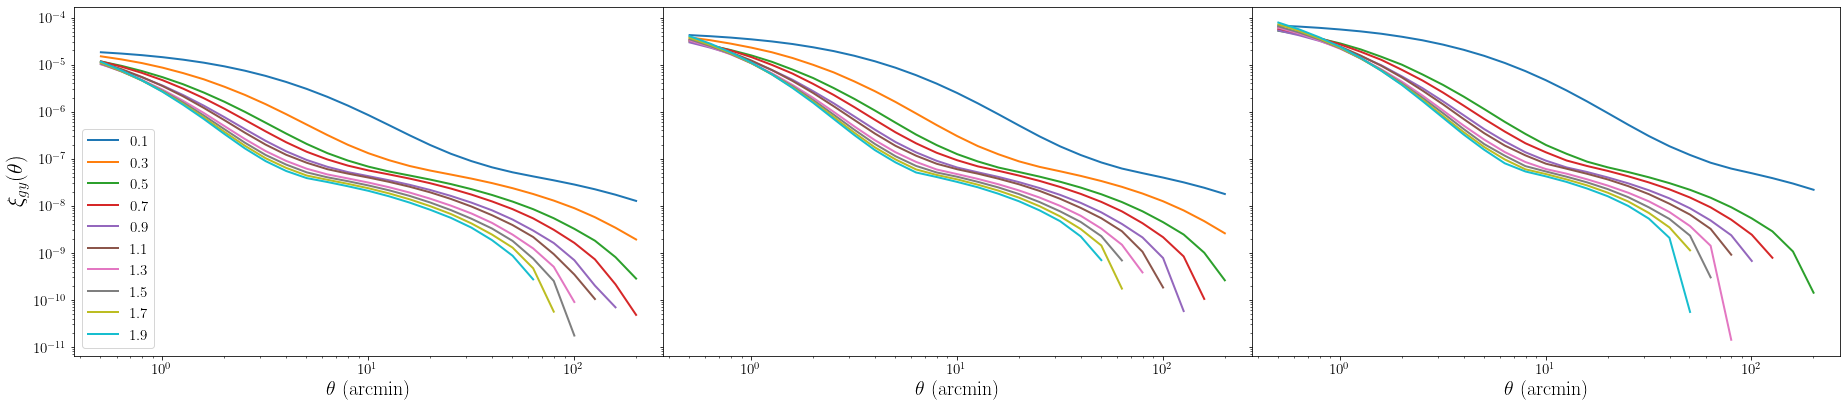

In [17]:
fdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/'
import scipy.interpolate as interpolate
ytype = 'planck'
# ytype = 'act'
do_residuals = 0
show_1h2h = 0
show_chi2 = 1

fnames = [
            'DV_obj_temp_all_halos_hy_z_0p1_Mth_1e14.pk',
]

label_yx = 'MICE'
# ylims = [-1.2,1.2]
sc = [20,10,1.1,1.1]


    
    
labels = ['Bestfit','DES Cosmo','OWLS AGN']
# labels = ['Mead',r'$R_{\rm max}/R_{\rm 200c} = 3$',r'$R_{\rm max}/R_{\rm 200c} = 2$']
colors = ['r','b','g']
nbins = 4
bins = (np.arange(4) + 1).astype(int)
fig, ax = pl.subplots(1,3, figsize = (26,6),sharex=True,sharey='row', gridspec_kw = {'hspace':0,'wspace':0})
zmins = np.array([0.09,0.29,0.49,0.69,0.89,1.09,1.29,1.49,1.69,1.89])
zmaxs = np.array([0.11,0.31,0.51,0.71,0.91,1.11,1.31,1.51,1.71,1.91])
zmeans = 0.5*(zmins+zmaxs)
Mths = np.array([14.0,14.4,14.6])
all_data = {}
for j2 in range(3):
    savezth = {}
    for jf in range(len(zmins)):
#         
        fname = 'DV_obj_temp_all_halos_hy_M_' + str(Mths[j2]) + '_z_' + str(zmins[jf]) + '_' + str(zmaxs[jf]) + '.pk'
        DV = dill.load(open(fdir + fname,'rb'))  

        jc = 0
        texts_kk = [r'1,1',r'2,2',r'3,3',r'4,4']
        texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']
        theta_array = DV.xi_result_dict['gy']['theta']
        bin_str = 'bin_' + str(1) + '_' + str(0)

        Cl_j1_tot = DV.xi_result_dict['gy'][bin_str]['tot']
#         sel_ind = np.where((bin1_gy == j2+1) & (bin2_gy == j2+1))[0]

        Cl_j1_1h = DV.xi_result_dict['gy'][bin_str]['1h']
        Cl_j1_2h = DV.xi_result_dict['gy'][bin_str]['2h']

        ax[j2].errorbar(theta_array, Cl_j1_tot, linestyle='-', marker='',lw = 2,label=str(zmeans[jf]))  
        if show_1h2h:
            ax[j2].errorbar(theta_array, Cl_j1_1h, linestyle='--', marker='',lw = 2, color =colors[jf],label='1-halo')  
            ax[j2].errorbar(theta_array, Cl_j1_2h, linestyle=':', marker='',lw = 2, color =colors[jf],label='2-halo')  
        savezth[zmeans[jf]] = {'1h':Cl_j1_1h,'2h':Cl_j1_2h,'tot':Cl_j1_tot}
        
#         ax[j2].axvspan(0,sc[j2],alpha=0.08,color='k')
        ax[j2].set_xscale('log')

#         if do_residuals:
#             ax[j2].set_ylim(ylims)        
#         else:
        ax[j2].set_yscale('log')
#             ax[j2].set_ylim(3e-9,7e-7)


        ax[j2].set_xlabel(r'$\theta$ (arcmin)', size = 20)
#         ticks  = np.array([3,10,30,100])
#         labels_bottom = ticks
#         ax[j2].set_xticks(ticks)
#         ax[j2].set_xticklabels(labels_bottom,  fontsize=15)

        ax[j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[j2].tick_params(axis='both', which='major', labelsize=15)
#         ax[j2].set_xlim((2,250))
#         ax[j2].text( 0.75, 0.96,str(j2+1) + ',y', verticalalignment='top', horizontalalignment='left', transform=ax[j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    

        jc += 1

#     if do_residuals:
#         ax[0].set_ylabel(r'$\Delta \xi_{gy}/\xi^{\rm bestfit}_{gy}$ ', size = 22)
#     else:
    all_data[Mths[j2]] = savezth
    all_data['theta'] = theta_array
    ax[0].set_ylabel(r'$\xi_{gy}(\theta)$ ', size = 22)
    ax[0].legend(fontsize=15,loc='lower left')
    
pl.tight_layout()

# fig.savefig('xi_sims_residual_' + str(ytype) + '.pdf')







In [18]:
pk.dump(all_data,open('save_halo_y_zv_Mth.pk','wb'))
